In [1]:
"""
Here I will build an RNN to implement the 2-Bit Flip task. This is generally modelled after (https://direct.mit.edu/neco/article/25/3/626/7854/Opening-the-Black-Box-Low-Dimensional-Dynamics-in)
where they implement a 3-Bit flip task and then break down the phase space to interpret how the network is implementing the computation. I would eventually like to do the same in models I build to
mimic the Medulla by reproducing motor outputs, however I will start here to practice in a simpler case.
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import zutils
import matplotlib.pyplot as plt

torch.Size([50, 100, 2])
torch.Size([50, 100, 2])


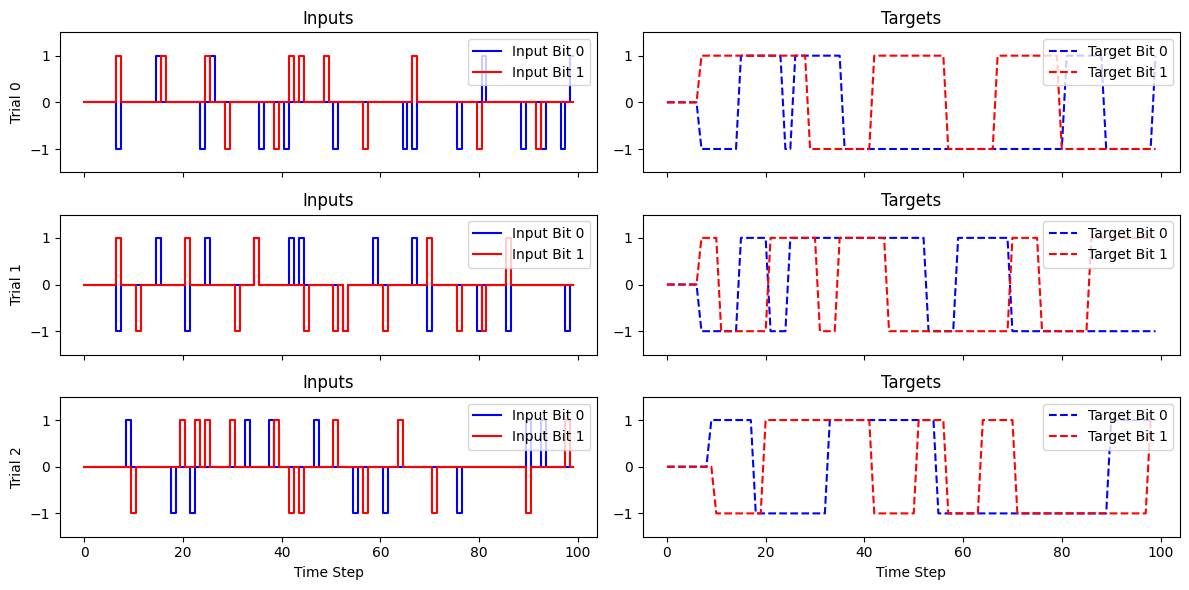

In [2]:
"""
Create and visualize the dataset
"""

X, Y = zutils.generate_2bit_flipflop_dataset(num_trials=50, trial_length=100, seed=42)
print(X.shape)  # (10, 40, 2)
print(Y.shape)  # (10, 40, 2)

zutils.plot_flipflop_trials(X, Y, num_trials_to_plot=3)


In [9]:
class FlipFlopRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, output_size=2, num_layers=1):
        super(FlipFlopRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bias=False,
                          nonlinearity='tanh')
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)  # out shape: (batch, seq_len, hidden_size)
        out = self.output_layer(out)  # out shape: (batch, seq_len, output_size)
        return out


In [10]:
# Generate toy dataset
X_train, Y_train = zutils.generate_2bit_flipflop_dataset(num_trials=2000, trial_length=100, seed=42)
X_val, Y_val = zutils.generate_2bit_flipflop_dataset(num_trials=500, trial_length=100, seed=42)
X_test, Y_test = zutils.generate_2bit_flipflop_dataset(num_trials=100, trial_length=100, seed=42)

# Initialize model
model = FlipFlopRNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

val_loss_storage = []
val_accuracy_storage = []

# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, Y_train)
    loss.backward()
    optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_accuracy = zutils.flipflop_accuracy(val_outputs, Y_val)
        val_loss = loss_fn(val_outputs, Y_val)

        val_accuracy_storage.append(val_accuracy)
        val_loss_storage.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.9755, Val Loss: 0.9538, Val Acc: 0.0458
Epoch 2, Train Loss: 0.9549, Val Loss: 0.9342, Val Acc: 0.0458
Epoch 3, Train Loss: 0.9351, Val Loss: 0.9139, Val Acc: 0.0458
Epoch 4, Train Loss: 0.9148, Val Loss: 0.8917, Val Acc: 0.0458
Epoch 5, Train Loss: 0.8924, Val Loss: 0.8656, Val Acc: 0.0458
Epoch 6, Train Loss: 0.8663, Val Loss: 0.8333, Val Acc: 0.0458
Epoch 7, Train Loss: 0.8340, Val Loss: 0.7913, Val Acc: 0.0459
Epoch 8, Train Loss: 0.7921, Val Loss: 0.7342, Val Acc: 0.0461
Epoch 9, Train Loss: 0.7353, Val Loss: 0.6601, Val Acc: 0.0530
Epoch 10, Train Loss: 0.6614, Val Loss: 0.6546, Val Acc: 0.0656
Epoch 11, Train Loss: 0.6541, Val Loss: 0.6078, Val Acc: 0.0770
Epoch 12, Train Loss: 0.6081, Val Loss: 0.5646, Val Acc: 0.0840
Epoch 13, Train Loss: 0.5660, Val Loss: 0.5518, Val Acc: 0.0878
Epoch 14, Train Loss: 0.5537, Val Loss: 0.5405, Val Acc: 0.0954
Epoch 15, Train Loss: 0.5426, Val Loss: 0.5198, Val Acc: 0.1064
Epoch 16, Train Loss: 0.5220, Val Loss: 0.4910, V

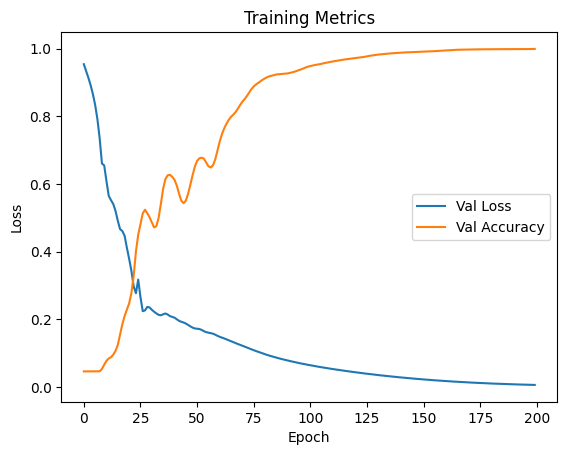

In [11]:
plt.plot(val_loss_storage, label="Val Loss")
plt.plot(val_accuracy_storage, label="Val Accuracy")
plt.title("Training Metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [12]:
model.eval()
x, y = X_test, Y_test
with torch.no_grad():
    pred = model(x)


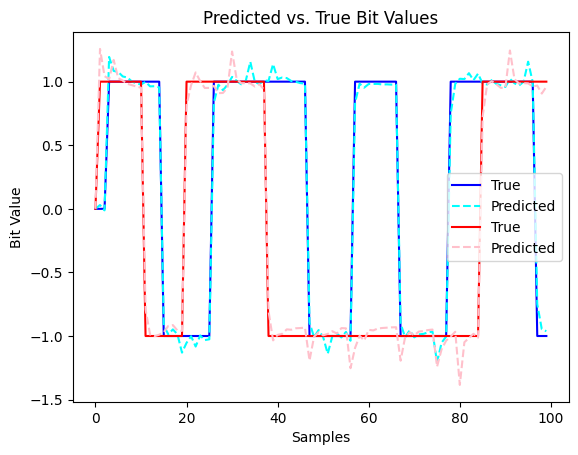

In [13]:
trial=9
bit=0

plt.plot(y[trial][:,0], label="True", color="b")
plt.plot(pred[trial][:,0], linestyle="--", label="Predicted", color="cyan")

plt.plot(y[trial][:,1], label="True", color="r")
plt.plot(pred[trial][:,1], linestyle="--", label="Predicted", color="pink")

plt.xlabel("Samples")
plt.ylabel("Bit Value")
plt.legend()
plt.title("Predicted vs. True Bit Values")
plt.show()